# (Try to) identify signals of gentrification from Airbnb data

_Code used to generate a paper for the GISRUK 2025 conference_.

Building on previous scripts (twitter sentiment and foursquare gentrification), this script uses data from [Inside AirBnB](https://insideairbnb.com/) and an LLM to see whether there might be indicators of the level of gentrification in an area. Ultimately we would like to repeat this for different years to see if gentrification patterns emerge.

In [1]:
import os
import re

import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.stats import zscore


from datetime import datetime

from IPython.core.pylabtools import figsize
from fontTools.varLib.interpolatableHelpers import matching_for_vectors
#from pygments.lexers.textfmts import TodotxtLexer
from together import Together  # pip install together

from statsmodels.stats.inter_rater import fleiss_kappa

## Data

Data were downloaded for Bristol from [Inside AirBnB](https://insideairbnb.com/get-the-data/) from a snapshot taken on 23 September, 2024. I use the three 'details' files:
   - `listings.csv.gz`
   - `reviews.csv.gz`
   - `neighbourhoods.geojson`

The downloaded files need to be placed in a directory called [airbnb-bristol](./airbnb-bristol) in the same directory as this script (not uploaded to github).

In [2]:
#from networkx.classes import restricted_view

listings = pd.read_csv("../data/airbnb-bristol/listings.csv.gz")
reviews = pd.read_csv("../data/airbnb-bristol/reviews.csv.gz")
neighbourhoods = gpd.read_file("../data/airbnb-bristol/neighbourhoods.geojson")

# Use the lat/lon columsn to make the listings a geodataframe
listings = gpd.GeoDataFrame(listings, geometry=gpd.points_from_xy(listings.longitude, listings.latitude))

In [3]:
print(f"Have read {len(listings)} listings, {len(reviews)} reviews, and {len(neighbourhoods)} neighbourhoods.\n"
      f"They were last scraped on {listings.last_scraped.min()}.")

assert len(listings.last_scraped.unique()) == 1, "For some reason there are multiple last_scraped dates in the listings file."

Have read 2644 listings, 138036 reviews, and 34 neighbourhoods.
They were last scraped on 2024-09-23.


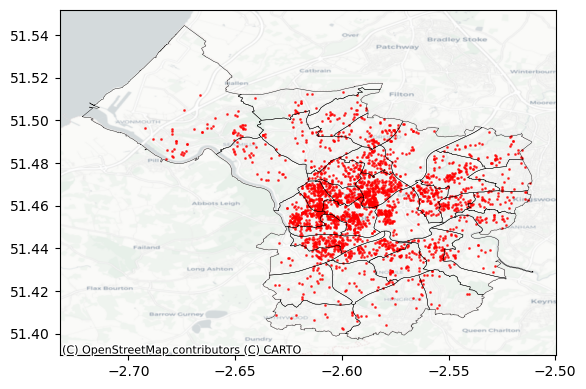

In [6]:
ax = neighbourhoods.plot(edgecolor="black", facecolor="none", linewidth=0.3, zorder=3)

# Plot the listings
listings.plot(ax=ax, color='red', markersize=1, alpha=0.7, zorder=2)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=neighbourhoods.crs.to_string(), zorder=1)

# Adjust the axis for a clean appearance
#ax.set_axis_off()

ax.figure.savefig("../data/airbnb-bristol/listing_locations.png", dpi=300, bbox_inches="tight")

## Gentrification in Bristol

Initially just use the listing descriptions. Later we can try the reviews for the listings as well by merging on IDs


In [7]:
# We need a single 'text' column later. Combine the listing text and the neighbourhood overview
listings.loc[:, 'text'] = listings['description'] + " " + listings['neighborhood_overview']
# Drop Nan
listings = listings.dropna(subset=['text'])
listings.loc[:, ['id', 'description', 'neighborhood_overview', 'text']]

,id,description,neighborhood_overview,text
0,70820,A good sized room with a comfy double bed and ...,The neighbourhood is friendly and welcoming; m...,A good sized room with a comfy double bed and ...
1,117122,My Harbourside apartment centrally located min...,This area is on the water and has splendid vie...,My Harbourside apartment centrally located min...
2,176306,"A small double room in an artist's house, with...","Southville is pretty darn hip, frankly. North ...","A small double room in an artist's house, with..."
3,307634,"Close to Bristol and Bath Railway Path, leadin...",Located in the cosmopolitan and bohemian commu...,"Close to Bristol and Bath Railway Path, leadin..."
4,390781,A room with a shared bathroom in an old Victor...,"Meals/food not provided, as the house is next ...",A room with a shared bathroom in an old Victor...
...,...,...,...,...
2586,1227444928057739404,Cosy One Bedroom basement flat in the heart of...,Staying here means you’re close to the popular...,Cosy One Bedroom basement flat in the heart of...
2587,1227506470486621314,Our apartment is close to the ever popular Nor...,"Being just off North Street, the area has a gr...",Our apartment is close to the ever popular Nor...
2590,1227597757085481104,This super cosy flat is central to all ameniti...,The neighbourhood is the bustling centre of Br...,This super cosy flat is central to all ameniti...
2606,1234125201720087498,Discover the perfect blend of city convenience...,The property is at the heart of the city and o...,Discover the perfect blend of city convenience...


### LLM gentrification function

Uses the Together.AI API.

A function that takes a batch of tweets and uses the Together API to classify them. The `system_prompt` variable contains the prompt that will be sent to the API; individual tweets are appended to this.

The LLM requires some parameter values. Here are the settings that chatGPT recommended (with defaults, that I decided not to use, in brackets)

1.	max_tokens:
	-	Recommendation: 50 (~1000 or more)
2.	temperature:
	-	Recommendation: 0.2 (0.7)
	-	Explanation: A lower temperature makes the model’s output more deterministic, which is ideal for scoring tasks where consistency is important.
3.	top_p:
	-	Recommendation: 0.9 (0.7)
	-	Explanation: This value balances the randomness and coherence of the output by considering tokens with a cumulative probability up to 90%.
4.	top_k:
	-	Recommendation: 40 (50)
	-	Explanation: Limits the model to consider the top 40 probable next tokens, which helps in generating relevant responses.
5.	repetition_penalty:
	-	Recommendation: 1.1 (1)
	-	Explanation: Slightly penalizes repeated tokens to prevent the model from producing redundant information.

In [8]:
# Create a log with the current time
LOG_FILE = os.path.join("logs", datetime.now().strftime("%Y-%m-%d-%H%M%S.log"))
def log(msg):
    with open(LOG_FILE, 'a') as f:
        f.write(msg)

In [9]:
def get_gentrification_scores(batch_tweets, system_prompt, client, batch_index=0, max_tokens=1000):
    """
    Retrieves gentrification scores for a batch of tweets using the Together AI API.

    Parameters
    ----------
    batch_tweets : pandas.DataFrame
        A DataFrame containing the tweets for the current batch.
        It must include a 'text' column with the tweet content.
    system_prompt : str
        The system prompt to be sent to the Together AI API.
        The tweet texts will be appended to this prompt.
    client : Together
        The Together client object to use for API calls.
    batch_index : int
        An optional starting index of the current batch.
        This is used to align the predicted sentiments with the original DataFrame indices.

    Returns
    -------
    ids : list of int
        A list of DataFrame indices corresponding to each tweet in the batch.
        These indices align with the main DataFrame from which this batch was drawn.
    sentiments : list of str
        A list of predicted gentrification scores for each tweet in the batch.
        Possible values are 1 (not suggestive of gentrification) to 5 (highly suggestive).
    explanations : list of str
        Explanations that the LLM returns giving it's reason for the the chosen score
        (these may or may not happen depending on the prompt, and the LLM's mood!)
    """

    # Prepare the list of tweets
    tweet_list = "\n".join([f"{idx + 1}. {tweet}"
                            for idx, tweet in enumerate(batch_tweets.text.values)])

    # Create the system prompt
    system_prompt = f"{system_prompt}\n\n{tweet_list}"
    #print("PROMPT:", system_prompt, "\n\n")

    # Prepare the messages
    messages = [
        {
            "role": "system",
            "content": system_prompt
        }
    ]

    # Call the API using parameters that ChatGPT recommends for this task
    response = client.chat.completions.create(
        #model="meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo",
        model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
        messages=messages,
        max_tokens=max_tokens,  # max length of output (in case I get the prompt wront and it talks for ages...)
        temperature=0.2,  # lower for more deterministic
        top_p=0.9,  # ??
        top_k=40,  # ??
        repetition_penalty=1,
        stop=["<|eot_id|>", "<|eom_id|>"],
        #truncate=130560,  # ??
        stream=False  # Set stream to False to get the full response
    )

    # Extract the assistant's reply and get the IDs and scores
    assistant_reply = response.choices[0].message.content.strip()

    # Useful to have a full log for debugging etc
    log(f"{datetime.now().strftime('%Y-%m-%d-%H%M%S')}\n" \
        f"**MESSAGE**\n{messages}\n" \
        f"**RESPONSE**\n{assistant_reply}\n\n")

    # Parse the IDs and scores (and, if available the explanation for the score)
    ids = []
    scores = []
    explanations = []

    # Regex pattern to extract the line number, score, and optional text from a line
    pattern = r'''
        ^\s*              # Start of line, allow leading whitespace
        (\d+)             # Capture Group 1: The line number
        \s*[.:]\s*        # A dot or colon with optional whitespace
        (?:Score:\s+)?    # Optionally match "Score:" followed by one or more spaces
        (\d+)             # Capture Group 2: The score (one or more digits)
        (?:\s*(.*))?      # Optional text after the score (Group 3)
        $                 # End of the line
    '''

    # Desipte being told not to, sometimes the reply starts with
    # 'Here are the scores:' or 'Here are the analyses:'
    # Remove that, and any whitespace at the start or end
    assistant_reply = re.sub(r'^\s*Here are the scores:\s*', '', assistant_reply).strip()
    assistant_reply = re.sub(r'^\s*Here are the analyses:\s*', '', assistant_reply).strip()

    # Analyse the reply line-by-line
    lines = assistant_reply.strip().split('\n')
    error_count = 0  # Return -1 on an error (and count the number of errors at the same time)
    for i, line in enumerate(lines):
        # Ignore lines that are empty once they have been stripped
        line = line.strip()
        if not line:
            continue

        # Try to match the line
        match = re.match(pattern, line, re.VERBOSE)
        if match:
            # Extract the index and score from the match groups
            index = int(match.group(1))
            score = int(match.group(2))
            explanation = match.group(3)
            log(f"{i} {line}\n\t{index},{score},{explanation}")
            # Validate the score range
            if 1 <= score <= 5:
                ids.append(index)
                scores.append(score)
                explanations.append(explanation)
            else:
                msg = f"Warning: Score {score} out of range on line {i}: '{line}'"
                print(msg)
                log(msg)
                error_count += 1
        else:
            msg = f"\n*********************\n" \
                  f"Warning: Invalid format on line {i}: '{line}'.\n" \
                  f"The full response was: \n{assistant_reply}\n" \
                  f"*********************\n"
            print(msg)
            log(msg)
            error_count += 1
            break

        if index-1 >= len(batch_tweets):
            msg = f"Found {index} tweets, but there are more lines. Assuming remaining lines are junk and ignoring them."
            log(msg)
            print(msg)
            break

    if error_count > 0:
        # There was an error, set scores to -1 and assume tweet IDs from
        # 1 to len(batch_tweets).
        scores = [-1] * len(batch_tweets)
        ids = [x + 1 for x in range(len(batch_tweets))]
        explanations = ["ERROR"] * len(batch_tweets)

    # Compute dataframe indices
    df_ids = [batch_index + int(id) - 1 for id in ids]

    assert len(df_ids) == len(scores), f"Length of ids ({len(df_ids)} does not match length of scores ({len(scores)})."

    return df_ids, scores, explanations



### The Prompt

Use the slightly adapted Foursquare one for now

In [10]:
# This prompt asks explicitly for an explanation (note may need to make sure that 'max_tokens' in the call to the API is sufficiently large
prompt_explanatory = """
You are an expert in urban studies with a deep understanding of gentrification and how it is discussed in public discourse. I will provide you with some Airbnb listings. Your task is to analyse their text and determine the extent to which they suggest that the neighbourhood or area referenced is experiencing gentrification. Specifically:

Read the listings closely and identify any words, phrases, or implications that might indicate signs of gentrification, such as mentions of new luxury developments, rising rents, displacement of long-time residents, upscale amenities (e.g., artisanal coffee shops, craft breweries), changing demographics, or neighborhood 'revitalization'.

Consider both explicit and implicit cues. Explicit cues directly mention new businesses or rising prices, while implicit cues might reflect subtle neighborhood changes.

Assign a score from 1 to 5, where 1 means not suggestive of gentrification and 5 means highly suggestive.

Explain your reasoning in 1-2 sentences, referencing the specific words or phrases in the tweet that led you to your conclusion.

Provide your answer strictly in the format ‘1. Score. Reasoning.’, ‘2. Score. Reasoning’, '3. Score. Reasoning', etc., without any additional explanation or commentary.
"""

# The propmpt to use (sometimes I have a few to choose between)
prompt = prompt_explanatory

### Run the LLM ?

Decide whether to run the LLM or load a file of scores that has been previously calculated and saved

In [11]:
# Check for existing files

base_dir = os.path.expanduser("~/gp/INTEGRATE/llm/data/airbnb-bristol/")
base_filename = "airbnb_gentrification_scores"
file_extension = ".gpkg"

# List all matching files in the directory
matching_files = [
    f for f in sorted(os.listdir(base_dir))
    if re.match(f"{base_filename}_\\d{{2}}{file_extension}$", f)
]
matching_files

['airbnb_gentrification_scores_01.gpkg',
 'airbnb_gentrification_scores_02.gpkg',
 'airbnb_gentrification_scores_03.gpkg']

In [12]:
# If there are matching files, find the most recent one
if matching_files:
    df = gpd.read_file(base_dir+matching_files[-1])
    print(f"Loaded file: {matching_files[-1]}")
else:
    # If no matching files are found
    print("No matching files found. 'df' will not be loaded.")
    df = None

Loaded file: airbnb_gentrification_scores_03.gpkg


If we have loaded a file, don't re-run the LLM by default (can override this if we want to create another file)

In [13]:
RUN_LLM = True
if df is not None:
    print("Have already loaded a gentrification file, will not re-run the LLM.")
    RUN_LLM = False

#RUN_LLM = True  # Optionally override

if RUN_LLM:
    print("Running LLM")
    # Get the API key from a file
    with open('together.ai_key.txt', 'r') as f:
        api_key = f.readline().strip()

    client = Together(api_key=api_key)

    # Sample for now?
    #df = listings.sample(50).copy()
    df = listings.copy()

    print(f"Will query the LM for {len(df)} items")

    assert len(df) < 3000, "Too many tweets to process in one go. Please reduce the number of tweets."

    # Ensure the index is consecutive and ascending
    df = df.reset_index(drop=True)
    # To store the results
    df['gentrification_prediction'] = None

    # Batch processing
    batch_size = 20
    for i in range(0, len(df), batch_size):
        # Get the batch of tweets
        batch_tweets = df.loc[i:i + batch_size - 1, :]

        # Get sentiments using the function
        print(f"Submitting batch {i//len(batch_tweets)+1} of {len(df)//len(batch_tweets)}...")

        ids, sentiments, explanations = get_gentrification_scores(
            batch_tweets, prompt, client, batch_index=i, max_tokens=1500)

        # Update the DataFrame with the predictions
        df.loc[ids, 'gentrification_prediction'] = sentiments
        df.loc[ids, 'explanation'] = explanations

        # Predictions should be integers
        df.gentrification_prediction = df.gentrification_prediction.astype('Int64')


    print("Finished querying LLM. Now saving file")

    # Initialize counter and check for existing files
    counter = 1
    while True:
        filename = f"{base_filename}_{counter:02d}{file_extension}"
        filepath = os.path.join(base_dir, filename)
        if not os.path.exists(filepath):
            break
        counter += 1
    df.set_crs(epsg=4326, inplace=True)
    df.to_file(filepath, layer="data", driver="GPKG")
    print(f"File saved as: {filepath}")

Have already loaded a gentrification file, will not re-run the LLM.


In [14]:
assert len(df) == len(listings), f"The number of rows in the dataframe {len(df)} does not match the number of listings {len(listings)}."
df.loc[:, ['id', 'name', 'description', 'neighborhood_overview', 'gentrification_prediction', 'explanation']]

,id,name,description,neighborhood_overview,gentrification_prediction,explanation
0,70820,City View - Sarah's double room.,A good sized room with a comfy double bed and ...,The neighbourhood is friendly and welcoming; m...,2,. Reasoning: The listing mentions a friendly a...
1,117122,City Centre-Waterside Retreat,My Harbourside apartment centrally located min...,This area is on the water and has splendid vie...,1,. Reasoning: The listing focuses on the apartm...
2,176306,The White Room - Central Bristol Art House Ga...,"A small double room in an artist's house, with...","Southville is pretty darn hip, frankly. North ...",4,. Reasoning: The listing highlights the area's...
3,307634,"'The Sunset Room' Peaceful, Clear Home","Close to Bristol and Bath Railway Path, leadin...",Located in the cosmopolitan and bohemian commu...,3,. Reasoning: The listing mentions a cosmopolit...
4,390781,"Cosy large room nr TV studios, Paintworks & st...",A room with a shared bathroom in an old Victor...,"Meals/food not provided, as the house is next ...",2,. Reasoning: The listing mentions a range of l...
...,...,...,...,...,...,...
1490,1227444928057739404,One Bedroom Basement Flat in Canynge Square,Cosy One Bedroom basement flat in the heart of...,Staying here means you’re close to the popular...,4,. Reasoning: The listing's emphasis on Clifton...
1491,1227506470486621314,Cosy two bedroom flat in the Poet Mews,Our apartment is close to the ever popular Nor...,"Being just off North Street, the area has a gr...",4,. Reasoning: The listing highlights North Stre...
1492,1227597757085481104,Clifton - Stylish 2 Bed Flat With Private Terr...,This super cosy flat is central to all ameniti...,The neighbourhood is the bustling centre of Br...,4,. Reasoning: The listing's description of the ...
1493,1234125201720087498,The Harbourside Haven | Bristol,Discover the perfect blend of city convenience...,The property is at the heart of the city and o...,5,. Reasoning: The listing's emphasis on the pro...


In [15]:
df.gentrification_prediction.value_counts().sort_index()

gentrification_prediction
1    213
2    300
3    259
4    435
5    288
Name: count, dtype: int64

Map the scores, colouring by gentrification prediction

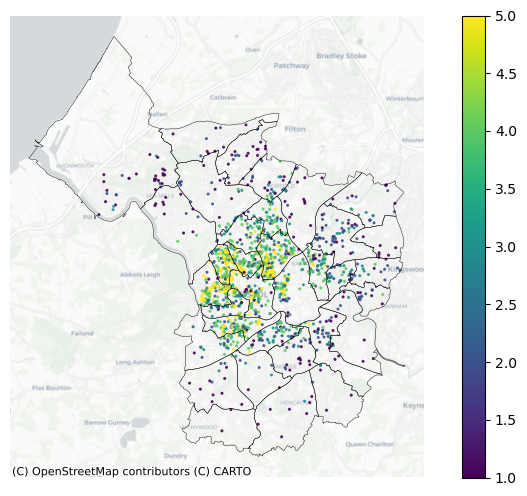

In [16]:
# Create a figure with the desired size
fig, ax = plt.subplots(figsize=(10, 6))

neighbourhoods.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.3, zorder=3)

# Plot the listings, colouring by gentrification score
df.plot(ax=ax, column='gentrification_prediction', markersize=1.5, alpha=0.8, zorder=2, legend=True)
#listings.plot(ax=ax, color='red', markersize=1, alpha=0.7, zorder=2)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=neighbourhoods.crs.to_string(), zorder=1)

# Adjust the axis for a clean appearance
ax.set_axis_off()

ax.figure.savefig("../data/airbnb-bristol/listing_scores.png", dpi=300, bbox_inches="tight")

Lets also have a look at the listing cost

In [17]:
# Clean and convert 'price' column to float, handling commas and dollar signs
df['price_float'] = \
(
    df['price']
    .replace({None: np.nan})           # Replace None with NaN
    .str.replace(r'[\$,]', '', regex=True)  # Remove $ and , using regex
    .astype(float)                     # Convert to float
)

# Need a z score because there is a massive price
df['price_z'] = zscore(df['price_float'], nan_policy='omit')

# Even after normalising a couple of huge prices still skews loads, get rid of them
df.loc[df.price_z > 2, 'price'] = np.nan
df.loc[df.price_z > 2, 'price_z'] = np.nan

# Finally take account of the property size (bigger -> more expensive)
df['price_relative'] = df['price_z'] / df['accommodates']

#df.accommodates
#df.price_log

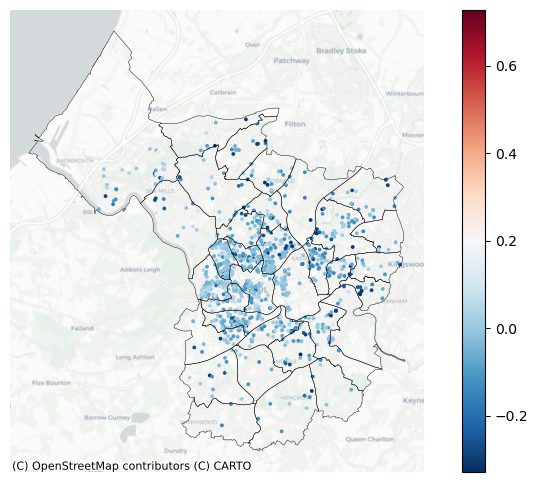

In [24]:
# Create a figure with the desired size
fig, ax = plt.subplots(figsize=(10, 6))

neighbourhoods.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.3, zorder=3)

# Plot the listings, colouring by gentrification score
df.plot(ax=ax, column='price_relative', markersize=3.0, alpha=1.0, zorder=2, legend=True,
    cmap="RdBu_r",  # Diverging color scheme
    vmin=df['price_relative'].min(),      # Optional: Define the range of z-scores
    vmax=df['price_relative'].max()
    )
#listings.plot(ax=ax, color='red', markersize=1, alpha=0.7, zorder=2)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=neighbourhoods.crs.to_string(), zorder=1)

# Adjust the axis for a clean appearance
ax.set_axis_off()


### Variability analysis

Load the three previously created files and examine the variability in the scores. Details of the variability analysis are in the [foursquare notebook](./2-gentrification_twitter.ipynb).

In [38]:
assert len(matching_files) >= 3, "Print I'm expecting at least 3 gentrification files"
dfs = [gpd.read_file(base_dir+f).set_index("id", drop=True) for f in matching_files]
assert len(dfs) == len(matching_files)

# Check each row represents the same listing
for i in range(1, len(dfs)):
    assert dfs[i].index.equals(dfs[0].index), f"IDs in file {i} do not match those in file 0."
    assert dfs[i].name.equals(dfs[0].name), f"Names in file {i} do not match those in file 0."

 Merge the three dataframes so that we have 3 columns, one for each prediction


In [49]:
merged_df = dfs[0].rename(columns={'gentrification_prediction': 'score_0',
                                  'explanation': 'explanation_0'})
for i in range(1, len(dfs)):
    merged_df = merged_df.merge(dfs[i].loc[:, ['gentrification_prediction', 'explanation']],
                                how='inner', left_index=True, right_index=True)
    merged_df = merged_df.rename(columns={'gentrification_prediction': f'score_{i}',
                                          'explanation': f'explanation_{i}'})
merged_df


,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,...,calculated_host_listings_count_shared_rooms,reviews_per_month,text,score_0,explanation_0,geometry,score_1,explanation_1,score_2,explanation_2
id,,,,,,,,,,,,,,,,,,,,,
70820,https://www.airbnb.com/rooms/70820,20240923134023,2024-09-23,previous scrape,City View - Sarah's double room.,A good sized room with a comfy double bed and ...,The neighbourhood is friendly and welcoming; m...,https://a0.muscache.com/pictures/b33c30be-56a0...,360195,https://www.airbnb.com/users/show/360195,...,0,1.47,A good sized room with a comfy double bed and ...,2,. Reasoning: The listing mentions a friendly a...,POINT (-2.59183 51.43843),2,. Reasoning: The listing mentions a friendly a...,2,. Reasoning: The listing mentions a friendly a...
117122,https://www.airbnb.com/rooms/117122,20240923134023,2024-09-23,city scrape,City Centre-Waterside Retreat,My Harbourside apartment centrally located min...,This area is on the water and has splendid vie...,https://a0.muscache.com/pictures/13b41142-0946...,591555,https://www.airbnb.com/users/show/591555,...,0,1.22,My Harbourside apartment centrally located min...,1,. Reasoning: The listing focuses on the apartm...,POINT (-2.61 51.44976),1,. Reasoning: The listing focuses on the apartm...,1,. Reasoning: The listing focuses on the apartm...
176306,https://www.airbnb.com/rooms/176306,20240923134023,2024-09-23,city scrape,The White Room - Central Bristol Art House Ga...,"A small double room in an artist's house, with...","Southville is pretty darn hip, frankly. North ...",https://a0.muscache.com/pictures/e1e7fdfc-9db5...,708175,https://www.airbnb.com/users/show/708175,...,0,0.39,"A small double room in an artist's house, with...",4,. Reasoning: The listing describes the neighbo...,POINT (-2.60297 51.44174),4,. Reasoning: The listing describes the neighbo...,4,. Reasoning: The listing highlights the area's...
307634,https://www.airbnb.com/rooms/307634,20240923134023,2024-09-23,city scrape,"'The Sunset Room' Peaceful, Clear Home","Close to Bristol and Bath Railway Path, leadin...",Located in the cosmopolitan and bohemian commu...,https://a0.muscache.com/pictures/e1be9894-84fb...,1582810,https://www.airbnb.com/users/show/1582810,...,0,0.48,"Close to Bristol and Bath Railway Path, leadin...",3,". Reasoning: The listing mentions a ""cosmopoli...",POINT (-2.5569 51.46487),3,". Reasoning: The listing mentions a ""cosmopoli...",3,. Reasoning: The listing mentions a cosmopolit...
390781,https://www.airbnb.com/rooms/390781,20240923134023,2024-09-23,previous scrape,"Cosy large room nr TV studios, Paintworks & st...",A room with a shared bathroom in an old Victor...,"Meals/food not provided, as the house is next ...",https://a0.muscache.com/pictures/77fed43a-04c9...,1954565,https://www.airbnb.com/users/show/1954565,...,0,0.39,A room with a shared bathroom in an old Victor...,2,. Reasoning: The listing mentions a range of l...,POINT (-2.55783 51.44444),2,. Reasoning: The listing mentions a range of l...,2,. Reasoning: The listing mentions a range of l...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227444928057739404,https://www.airbnb.com/rooms/1227444928057739404,20240923134023,2024-09-23,city scrape,One Bedroom Basement Flat in Canynge Square,Cosy One Bedroom basement flat in the heart of...,Staying here means you’re close to the popular...,https://a0.muscache.com/pictures/prohost-api/H...,65192629,https://www.airbnb.com/users/show/65192629,...,0,NaN,Cosy One Bedroom basement flat in the heart of...,4,. Reasoning: The listing highlights Clifton's ...,POINT (-2.62221 51.45923),5,. Reasoning: The listing mentions Clifton as a...,4,. Reasoning: The listing's emphasis on Clifton...
1227506470486621314,https://www.airbnb.com/rooms/1227506470486621314,20240923134023,2024-09-23,city scrape,Cosy two bedroom flat in the Poet Mews,Our apartment is close to the ever popular Nor...,"

Use **Fleiss' Kappa** as this compares all 'annotaters' (i.e. LLM attempts) simultaneously, rather than using Cohen's Kappa which only compares annotaters pairise (thanks ChatGPT)


In [51]:
score_columns = [f"score_{i}" for i in range(len(dfs))]
explanation_columns = [f"explanation_{i}" for i in range(len(dfs))]

# Table with just the scores
ratings = merged_df[score_columns]

# Identify unique categories
categories = sorted(ratings.stack().unique())  # e.g., ['1', '2', '3', '4']
# Give the categories indices (0--4)
category_to_idx = {cat: i for i, cat in enumerate(categories)}

N = len(merged_df)              # Number of items
k = len(categories)      # Number of categories

# Create a count matrix (N x k), where each cell is the count of how many raters assigned that category
# (So each row has a 5-element array which counts the number of raters giving eaach category (1--5)
count_matrix = np.zeros((N, k), dtype=int)

for i, row in enumerate(ratings.values):
    for val in row:
        col_idx = category_to_idx[val]
        count_matrix[i, col_idx] += 1

# Now use fleiss_kappa from statsmodels directly
kappa_value = fleiss_kappa(count_matrix)
print("Fleiss' Kappa:", kappa_value)


Fleiss' Kappa: 0.7430925188488167


The Fleiss' Kappa score of 0.74 suggests substantial agreement between the three LLM runs.